# Choosing step size for Inexact ALM algorithm

Saikat Banerjee  
2023-07-28

Try two different methods proposed for updating the penalty, which is
equivalent to the step size. (1) Lin et. al. proposed a monotonically
increasing step size. (2) Boyd proposed to dial the step size based on
the primal and dual residuals

# About

There are two alternate proposed methods for updating the penalty $\mu$
on the residual. The penalty is equivalent to the step size. Here, we
compare the two methods on a simulated dataset. The proposed methods
are:

-   Eq. 25 of [Lin et. al.](https://arxiv.org/abs/1009.5055)
-   Eq. 3.13 of [Boyd et.
    al.](https://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf)

To-Do: Check stopping criterion of Boyd et. al. using Eq. 3.12.

# Getting setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from nnwmf.optimize import IALM

# Simulate some toy data

In [2]:
ntrait = 4 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 40 # K

In [3]:
Y, Y_true, L, F, mean, noise_var, sample_indices = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, std = 0.5, do_shift_mean = False)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)
Y_std  = mpy_simulate.do_standardize(Y)
Y_true_cent = mpy_simulate.do_standardize(Y_true, scale = False)

In [4]:
unique_labels  = list(range(len(sample_indices)))
class_labels = [None for x in range(ngwas)]
for k, idxs in enumerate(sample_indices):
    for i in idxs:
        class_labels[i] = k

# IALM with default update of step size

In [5]:
rpca = IALM(benchmark = True, max_iter = 1000, show_progress = True)
rpca.fit(Y_cent, Xtrue = Y_cent)

2023-07-28 13:24:39,445 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.892391. Dual residual 0.00374201
2023-07-28 13:24:55,941 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 0.0031319. Dual residual 1.12454e-05
2023-07-28 13:25:11,945 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 200. Primal residual 2.69409e-06. Dual residual 1.09007e-05

# IALM with ADMM update of step size

In [6]:
rpca_admm = IALM(benchmark = True, max_iter = 1000, mu_update_method='admm', show_progress = True)
rpca_admm.fit(Y_cent, Xtrue = Y_cent)

2023-07-28 13:25:22,352 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.892391. Dual residual 0.00374201
2023-07-28 13:25:38,124 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 1.33026e-06. Dual residual 1.61284e-06

# Results

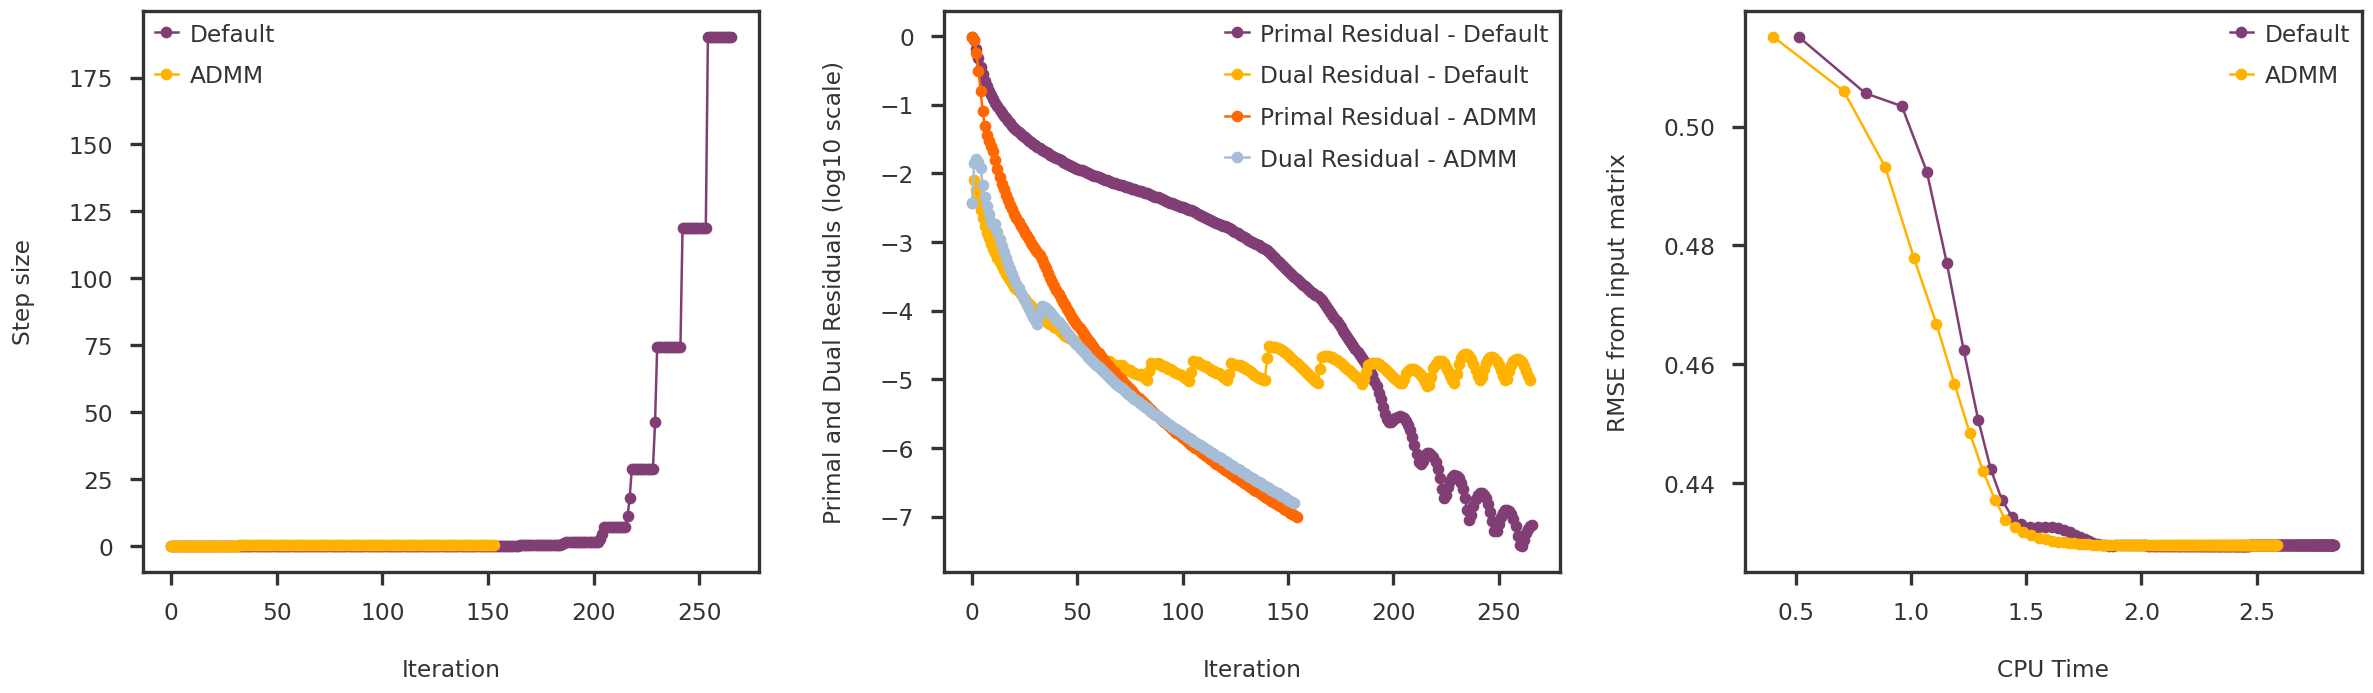

In [14]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(range(len(rpca.mu_list_)), rpca.mu_list_, 'o-', label = 'Default')
ax1.plot(range(len(rpca_admm.mu_list_)), rpca_admm.mu_list_, 'o-', label = 'ADMM')
ax1.legend()
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Step size")

ax2.plot(range(len(rpca.primal_res_)), np.log10(rpca.primal_res_), 'o-', label = 'Primal Residual - Default')
ax2.plot(range(len(rpca.dual_res_) - 1), np.log10(rpca.dual_res_[1:]), 'o-', label = 'Dual Residual - Default')
ax2.plot(range(len(rpca_admm.primal_res_)), np.log10(rpca_admm.primal_res_), 'o-', label = 'Primal Residual - ADMM')
ax2.plot(range(len(rpca_admm.dual_res_) - 1), np.log10(rpca_admm.dual_res_[1:]), 'o-', label = 'Dual Residual - ADMM')
ax2.legend()
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Primal and Dual Residuals (log10 scale)")

ax3.plot(np.log10(np.cumsum(rpca.cpu_time_[1:])), rpca.rmse_[1:], 'o-', label = 'Default')
ax3.plot(np.log10(np.cumsum(rpca_admm.cpu_time_[1:])), rpca_admm.rmse_[1:], 'o-', label = 'ADMM')
ax3.legend()
ax3.set_xlabel("CPU Time")
ax3.set_ylabel("RMSE from input matrix")

plt.tight_layout(w_pad = 2.0)
plt.show()

# Principal Components for the low rank matrix

## Default

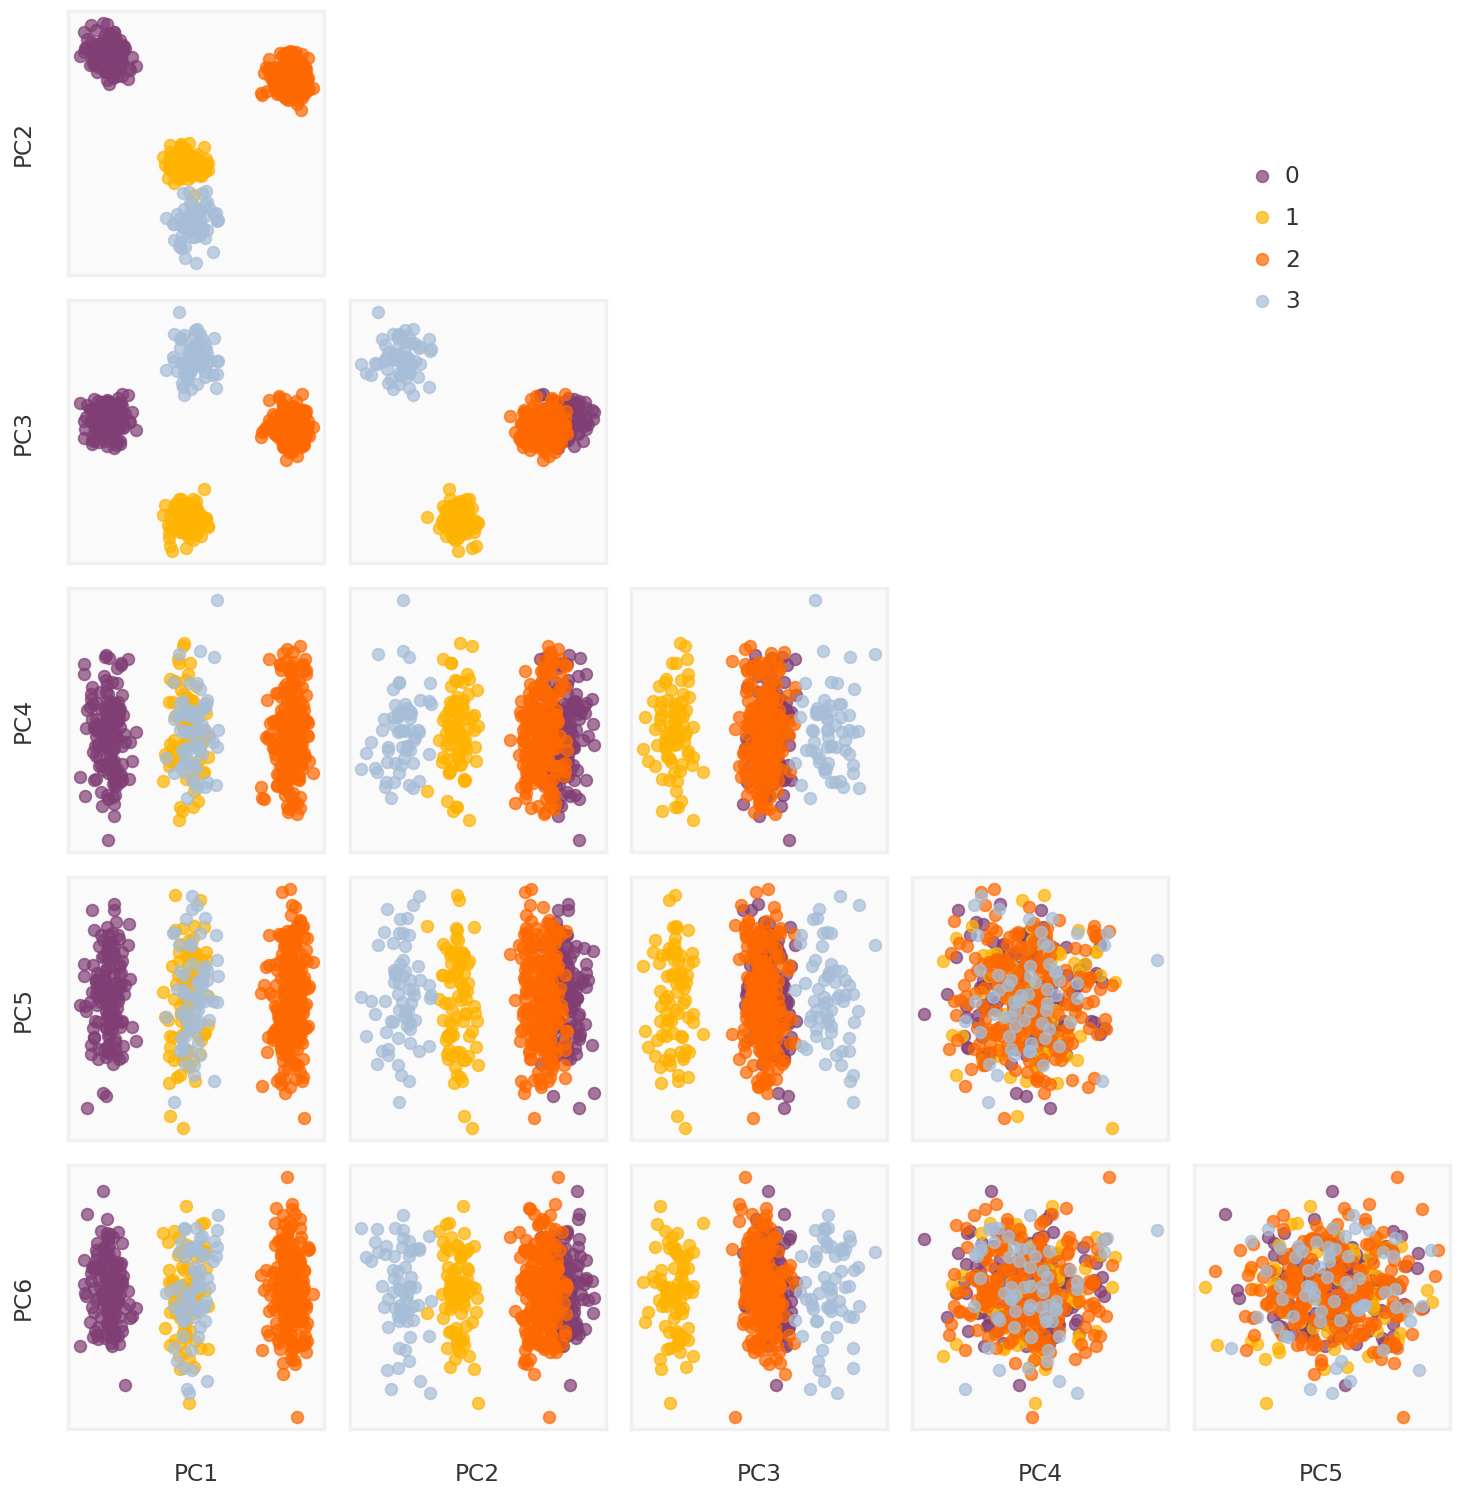

In [8]:
Y_rpca_cent = mpy_simulate.do_standardize(rpca.L_, scale = False)
U_rpca, S_rpca, Vt_rpca = np.linalg.svd(Y_rpca_cent, full_matrices = False)
pcomps_rpca = U_rpca @ np.diag(S_rpca)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, class_labels, unique_labels)
plt.show()

## ADMM

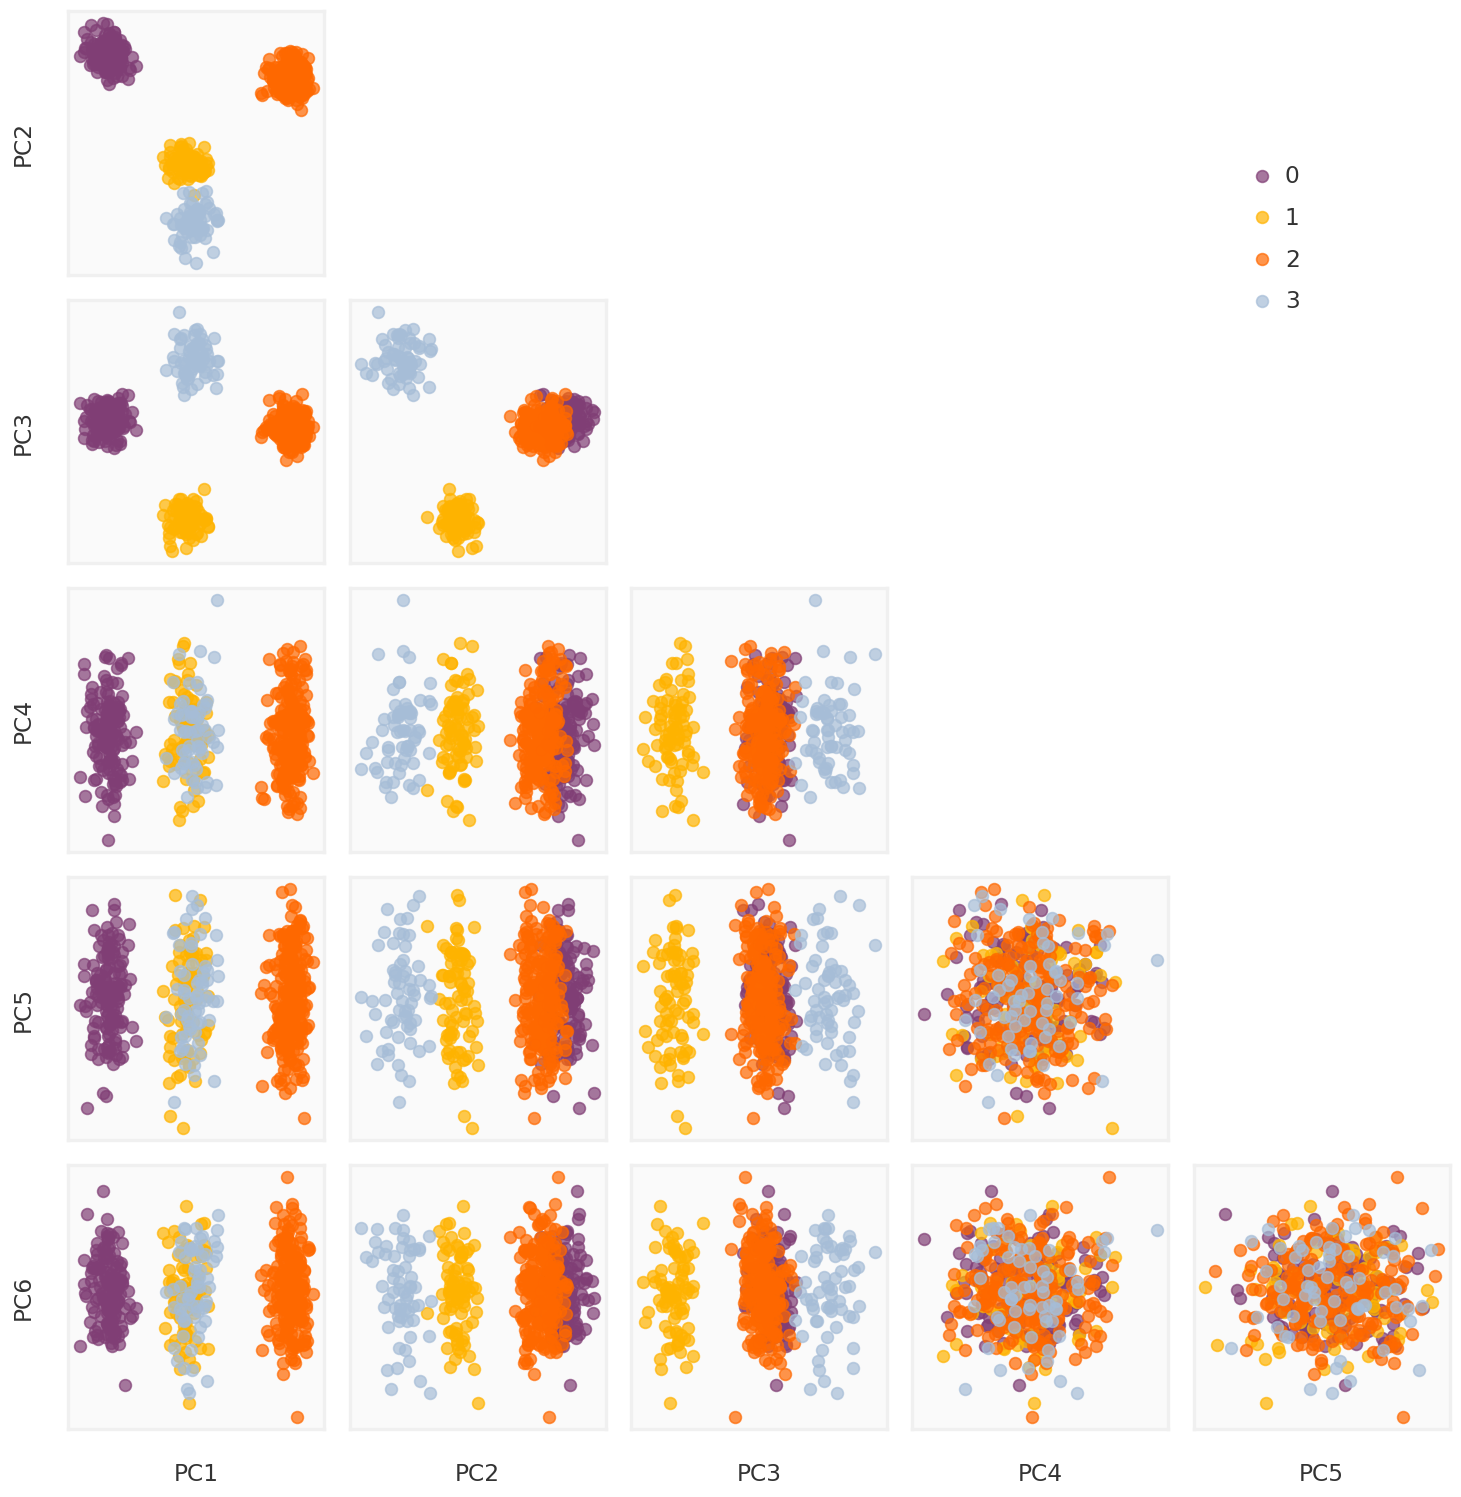

In [9]:
Y_rpca_cent = mpy_simulate.do_standardize(rpca_admm.L_, scale = False)
U_rpca, S_rpca, Vt_rpca = np.linalg.svd(Y_rpca_cent, full_matrices = False)
pcomps_rpca = U_rpca @ np.diag(S_rpca)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, class_labels, unique_labels)
plt.show()